# Mesa ABM of the Keep Threshold Relay

### Simulation notes and instructions

Notes:
* Nodes are created simulataneously using the Mesa SimultaneousActivation scheduler
* The nodes go through a bootstrap phase based on Antonio's diagram. They can only form groups if they are in the mainloop forked state.
* Relay requests are currently bernoulli trials
* Each step could be assumed to be a block
* Singature events are modeled by default as asynchronous with a step delay to mimick the block delay
* We assume that 1 node = 1 staker

Instructions:
1. Change variables
2. Click on the restart and run kernel icon for ipython


Check active group refresh function

In [1]:
import random
import simpy
import datetime
import numpy as np
import pandas as pd
import agent
import model
import matplotlib.pyplot as plt
import simulation_functions as sc

**Initialize Variables**

In [2]:
# Group Parameters
group_size = 10 # number of virtual stakers in a group - nodes to stakers is a 1-many relationship
nodes = 10 # total number of nodes (assume 1 node = 1 staker)
active_group_threshold =10 # number of active groups to bootstrap at start
min_nodes = 3 # min number of nodes that must be online so as to increase the likelihood of lower max ownership
min_honest_threshold = 20  # % of honest node ownership needed to sign 
max_malicious_threshold = 40 # % of malicious node ownership needed to sign
signature_delay = 2 # lambda for poisson distribution used to generate a delay before the signature is executed
group_expiry = 4 # number of steps after which a group expires

#Node parameters
node_failure_percent = 10 # % of times nodes fail and have to reconnect
node_death_percent = 5 # % of time nodes fail and do not reconnect


Text(0.5, 1.0, 'Virtual Staker Cumulative Distribution')

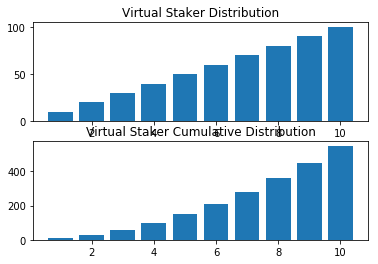

In [3]:
# Pre-processing Staker distributions
# Linear y = m * (x + 1) since indices start from 0
ticket_distribution = np.zeros(nodes) 

for i in range (0, nodes):
    ticket_distribution[i] =  10 * (i + 1) # m = 50 gives max y as 1000 which is 2% of 50000

x = np.linspace(1,nodes,nodes)
plt.subplot(2, 1, 1)
plt.bar(x, ticket_distribution)
plt.title("Virtual Staker Distribution")

cdf_L02=sc.create_cdf(nodes,ticket_distribution)
plt.subplot(2, 1, 2)
plt.bar(x, cdf_L02)
plt.title("Virtual Staker Cumulative Distribution")

In [4]:
beacon_model = model.Beacon_Model(nodes, ticket_distribution, 
                                  active_group_threshold, 
                                  group_size, 
                                  min_honest_threshold, 
                                  group_expiry, 
                                  node_failure_percent, 
                                  node_death_percent, 
                                  signature_delay,
                                  min_nodes
                                 )

In [5]:
active_group_size = []
signature_failures = []
for i in range (200):
    beacon_model.step()
    active_group_size.append(len(beacon_model.active_groups))
    print("signature failure events")
    print(beacon_model.unsuccessful_signature_events)
    

step # = 0
refreshing active nodes list
Number of nodes in the forked state = 0
bootstrapping active groups
relay request recieved? = False
     No relay request
signature failure events
[]
step # = 1
refreshing active nodes list
Number of nodes in the forked state = 0
bootstrapping active groups
relay request recieved? = True
     selecting group at random
low >= high
     no active groups available
     registering new group
             Not enough nodes to register a group
3 = just Failed
8 = just Failed
9 = just Failed
signature failure events
[]
step # = 2
refreshing active nodes list
Number of nodes in the forked state = 0
bootstrapping active groups
relay request recieved? = True
     selecting group at random
low >= high
     no active groups available
     registering new group
             Not enough nodes to register a group
signature failure events
[]
step # = 3
refreshing active nodes list
Number of nodes in the forked state = 0
bootstrapping active groups
relay request re

3 = just Failed
refreshing active nodes list
0
1
2
4
5
6
7
8
9
signature ownership data
[2. 0. 1. 0. 0. 0. 0. 2. 6. 0.]
[2. 0. 1. 0. 0. 0. 0. 2. 6. 0.]
failed nodes
node ID = 0agent ID = 0mainloop_status = forked
False
node ID = 1agent ID = 1mainloop_status = forked
False
node ID = 2agent ID = 2mainloop_status = forked
False
node ID = 3agent ID = 3mainloop_status = not forked
False
node ID = 4agent ID = 4mainloop_status = forked
False
node ID = 5agent ID = 5mainloop_status = forked
False
node ID = 6agent ID = 6mainloop_status = forked
False
node ID = 7agent ID = 7mainloop_status = forked
False
node ID = 8agent ID = 8mainloop_status = forked
False
node ID = 9agent ID = 9mainloop_status = forked
False
signature failure events
[]
step # = 41
refreshing active nodes list
0
1
2
4
5
6
7
8
9
Number of nodes in the forked state = 9
relay request recieved? = False
     No relay request
0 = just Failed
7 = just Failed
refreshing active nodes list
1
2
3
4
5
6
8
9
signature ownership data
[0. 0. 1

step # = 81
refreshing active nodes list
0
1
2
3
4
5
6
7
8
Number of nodes in the forked state = 9
relay request recieved? = False
     No relay request
5 = just Failed
signature failure events
[]
step # = 82
refreshing active nodes list
0
1
2
3
4
6
7
8
9
Number of nodes in the forked state = 9
relay request recieved? = True
     selecting group at random
     registering new group
refreshing active nodes list
0
1
2
3
4
5
6
7
8
9
signature ownership data
[0. 2. 0. 0. 0. 3. 3. 3. 0. 0.]
[0. 2. 0. 0. 0. 3. 3. 3. 0. 0.]
failed nodes
node ID = 0agent ID = 0mainloop_status = forked
False
node ID = 1agent ID = 1mainloop_status = forked
False
node ID = 2agent ID = 2mainloop_status = forked
False
node ID = 3agent ID = 3mainloop_status = forked
False
node ID = 4agent ID = 4mainloop_status = forked
False
node ID = 5agent ID = 5mainloop_status = forked
False
node ID = 6agent ID = 6mainloop_status = forked
False
node ID = 7agent ID = 7mainloop_status = forked
False
node ID = 8agent ID = 8mainloop_

3 = just Failed
4 = just Failed
9 = just Failed
refreshing active nodes list
0
1
2
5
6
7
8
signature ownership data
[0. 1. 3. 0. 1. 2. 0. 2. 2. 0.]
[0. 1. 3. 0. 0. 2. 0. 2. 2. 0.]
failed nodes
node ID = 0agent ID = 0mainloop_status = forked
False
node ID = 1agent ID = 1mainloop_status = forked
False
node ID = 2agent ID = 2mainloop_status = forked
False
node ID = 3agent ID = 3mainloop_status = not forked
False
node ID = 4agent ID = 4mainloop_status = not forked
False
node ID = 5agent ID = 5mainloop_status = forked
False
node ID = 6agent ID = 6mainloop_status = forked
False
node ID = 7agent ID = 7mainloop_status = forked
False
node ID = 8agent ID = 8mainloop_status = forked
False
node ID = 9agent ID = 9mainloop_status = not forked
False
signature failure events
[]
step # = 125
refreshing active nodes list
0
1
2
5
6
7
8
Number of nodes in the forked state = 7
relay request recieved? = True
     selecting group at random
     registering new group
1 = just Failed
2 = just Failed
5 = just F

8 = just Failed
9 = just Failed
signature failure events
[]
step # = 175
refreshing active nodes list
0
1
2
3
4
5
6
7
Number of nodes in the forked state = 8
relay request recieved? = True
     selecting group at random
     registering new group
refreshing active nodes list
0
1
2
3
4
5
6
7
8
9
signature ownership data
[0. 0. 0. 1. 2. 1. 1. 3. 1. 2.]
[0. 0. 0. 1. 2. 1. 1. 3. 1. 2.]
failed nodes
node ID = 0agent ID = 0mainloop_status = forked
False
node ID = 1agent ID = 1mainloop_status = forked
False
node ID = 2agent ID = 2mainloop_status = forked
False
node ID = 3agent ID = 3mainloop_status = forked
False
node ID = 4agent ID = 4mainloop_status = forked
False
node ID = 5agent ID = 5mainloop_status = forked
False
node ID = 6agent ID = 6mainloop_status = forked
False
node ID = 7agent ID = 7mainloop_status = forked
False
node ID = 8agent ID = 8mainloop_status = forked
False
node ID = 9agent ID = 9mainloop_status = forked
False
signature failure events
[]
step # = 176
refreshing active nod

2.0


Text(0, 0.5, 'active groups')

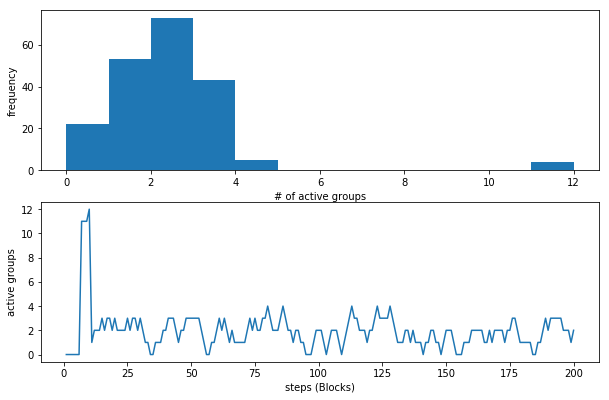

In [6]:
plt.figure(figsize = (10,10))
plt.subplot(3, 1, 1)
plt.hist(active_group_size, bins=range(max(active_group_size)+1))
plt.xlabel("# of active groups")
plt.ylabel("frequency")
print(np.median(active_group_size))

plt.subplot(3, 1, 2)
plt.plot(np.linspace(1,len(active_group_size),len(active_group_size)),active_group_size)
plt.xlabel("steps (Blocks)")
plt.ylabel("active groups")


Median Group ownership = 36.0


AttributeError: 'Signature' object has no attribute 'end_signature_process'

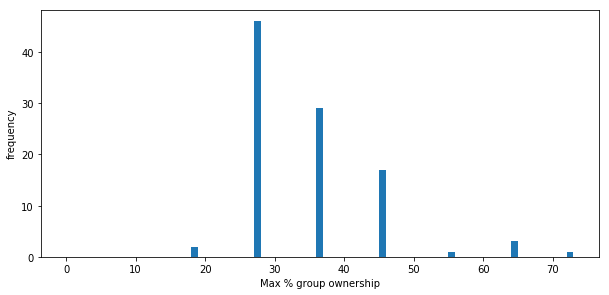

In [7]:

max_group_ownership = []
max_node_index = []
for group in beacon_model.schedule.agents:
    if group.type == "group":
        #print(group.ownership_distr)
        #print(max(group.ownership_distr)/sum(group.ownership_distr)*100)
        max_group_ownership.append(int(round(max(group.ownership_distr)/sum(group.ownership_distr)*100)))

plt.figure(figsize = (10,10))
plt.subplot(2, 1, 1)
plt.hist(max_group_ownership, bins=range(max(max_group_ownership)+1))
plt.xlabel("Max % group ownership")
plt.ylabel("frequency")
print("Median Group ownership = " + str(np.median(max_group_ownership)))

max_signature_ownership = []
for signature in beacon_model.schedule.agents:
    if signature.type == "signature" and signature.end_signature_process:
        #print(signature.id)
        #print(signature.ownership_distr)
        max_signature_ownership.append(int(round(max(signature.ownership_distr)/sum(signature.ownership_distr)*100)))

plt.subplot(2, 1, 2)
plt.hist(max_signature_ownership, bins=range(max(max_signature_ownership)+1))
plt.xlabel("Max % signature ownership")
plt.ylabel("frequency")
print("Median Signature ownership = " + str(np.median(max_signature_ownership)))

**Further Questions**

* Whats the distribution of group ownership for each node that owns at least 1 group

In [ ]:
# Calculate ownership distributions for the node(s) with the largest % ownership
node_ownership_percent= []
node_id = []
for node in beacon_model.schedule.agents:
    if node.type == "node":
        temp = []
        for group in beacon_model.schedule.agents:
            if group.type == "group":
                temp.append(round(group.ownership_distr[node.id]/sum(group.ownership_distr)*100))
        node_ownership_percent.append(temp)
        node_id.append(node.id)

In [ ]:
# Finds the nodes with max ownership % and the picks the one out of that group with the max cumulative total ownership
node_ownership_percent = np.array(node_ownership_percent)
max_node_indices = np.argwhere((node_ownership_percent>=np.amax(node_ownership_percent)))
#index = np.unravel_index(np.argmax(node_ownership_percent, axis=None), node_ownership_percent.shape)
#print(index)
node_ownership_sum = 0
max_node_index = []
for node in max_node_indices:
    #print(node[0])
    #print(sum(node_ownership_percent[node[0]]))
    if sum(node_ownership_percent[node[0]])>node_ownership_sum:
        node_ownership_sum = sum(node_ownership_percent[node[0]])
        max_node_index = node
    #print(max_node_index)
    
plt.figure(figsize = (10,10))
plt.subplot(2, 1, 1)
plt.hist(node_ownership_percent[max_node_index[0]], bins=range(int(max(node_ownership_percent[max_node_index[0]])+1)))
plt.xlabel("strongest node group ownership %")
plt.ylabel("frequency")
        
print(node_ownership_percent[max_node_index[0]])
        

* what % of nodes own at least 1 group

In [ ]:
# count the number of nodes that have no group ownerhship at all, subtract from one to get answer
no_ownership_count = 0
for node in node_ownership_percent:
    if sum(node)==0:
        no_ownership_count +=1
        
print(1-no_ownership_count/nodes)

* How many of the signatures produces have a single actor in control
* control = 

In [ ]:
# for each group count the number of successful signature events 
group_signature_events = []
group_successes = []
group_sign_ratio = []
for group in beacon_model.schedule.agents:
    if group.type == "group":
        group_sign_total = 0
        group_sign_successes = 0
        #print("group id = "+str(group.id))
        for signature in beacon_model.schedule.agents:
            if signature.type == "signature":
                #print("signature id = "+str(signature.id))
                if signature.group.id == group.id:
                    group_sign_total +=1 # count the total number of signature events this group participates in
                    group_sign_successes += signature.signature_success # count the number of successes
        group_signature_events.append(group_sign_total)
        group_successes.append(group_sign_successes)
        if group_sign_total>0:
            group_sign_ratio.append(round(group_sign_successes/group_sign_total*100))
        else:
            group_sign_ratio.append(0)

print(group_sign_ratio)
print(group_signature_events)
print(group_successes)
            
    
plt.figure(figsize = (10,10))
plt.subplot(2, 1, 1)
plt.hist(group_signature_events, bins=range(int(max(group_signature_events))+1))
plt.xlabel("Group Signature Events")
plt.ylabel("frequency")

plt.subplot(2, 1, 2)
plt.hist(group_sign_ratio, bins=range(int(max(group_sign_ratio))+1))
plt.xlabel("Group sign success ratio")
plt.ylabel("frequency")

